In [0]:
!pip install pycm livelossplot torchvision
%pylab inline

     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 542kB 36.1MB/s 
Populating the interactive namespace from numpy and matplotlib


In [0]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True


device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available! I have reached the GPU usage limits on Google Colab, so I cannot use it")

Cuda installed! Running on GPU!


In [0]:
## mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
from zipfile import ZipFile
from io import BytesIO
import PIL.Image
from IPython.display import display

In [0]:
def load_image(filename):
    image = PIL.Image.open(filename) # open colour image
    image = np.array(image)
    
    return np.float32(image)

In [0]:
def plot_image(image):
    # Assume the pixel-values are scaled between 0 and 255.
    
    # Convert the pixel-values to the range between 0.0 and 1.0
    image = np.clip(image/255.0, 0.0, 1.0)
        
    # Plot using matplotlib.
    plt.imshow(image, interpolation='lanczos')
    plt.show()

In [0]:
archive = ZipFile("/content/gdrive/My Drive/acse-miniproject.zip", 'r')
archive.namelist()[0:5]

['mapping.json',
 'mapping.py',
 'test/images/test_0.JPEG',
 'test/images/test_1.JPEG',
 'test/images/test_10.JPEG']

In [0]:
## train images start at index 10002
print(archive.namelist()[10001])
print(archive.namelist()[10002])
print(archive.namelist()[10003])

test/images/test_9999.JPEG
train/n01443537/images/n01443537_0.JPEG
train/n01443537/images/n01443537_1.JPEG


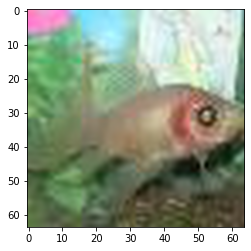

In [0]:
image = load_image(filename=BytesIO(archive.read(archive.namelist()[10002])))
plot_image(image)

In [0]:
archive = archive.namelist()[10002:]

In [0]:
archive[0]

'train/n01443537/images/n01443537_0.JPEG'

In [0]:
!unzip "/content/gdrive/My Drive/acse-miniproject.zip" -d "/content/gdrive/My Drive/Logistic"

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/My Drive/Logistic/train/n07871810/images/n07871810_108.JPEG  
  inflating: /content/gdrive/My Drive/Logistic/train/n07871810/images/n07871810_109.JPEG  
  inflating: /content/gdrive/My Drive/Logistic/train/n07871810/images/n07871810_11.JPEG  
  inflating: /content/gdrive/My Drive/Logistic/train/n07871810/images/n07871810_110.JPEG  
  inflating: /content/gdrive/My Drive/Logistic/train/n07871810/images/n07871810_111.JPEG  
  inflating: /content/gdrive/My Drive/Logistic/train/n07871810/images/n07871810_112.JPEG  
  inflating: /content/gdrive/My Drive/Logistic/train/n07871810/images/n07871810_113.JPEG  
  inflating: /content/gdrive/My Drive/Logistic/train/n07871810/images/n07871810_114.JPEG  
  inflating: /content/gdrive/My Drive/Logistic/train/n07871810/images/n07871810_115.JPEG  
  inflating: /content/gdrive/My Drive/Logistic/train/n07871810/images/n07871810_116.JPEG  
  inflating: /content/gdrive/My Drive/Lo

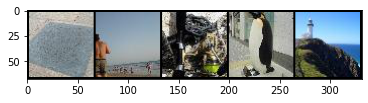

78
198
139
21
71


In [0]:
batch_size = 5

def load_dataset(data_path='/content/gdrive/My Drive/Logistic/train/'):
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return train_loader

trainloader = load_dataset()
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    # convert to numpy array for imshow()
    npimg = img.numpy()
    # transpose to show the image correctly
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

classes = [i for i in range(200)]
for i in range(batch_size):
  print(classes[labels[i]])

In [0]:
## calculate the mean and std
train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
batch_size = 100000
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)

pop_mean = []
pop_std0 = []
pop_std1 = []
for inputs, labels in dataloader:
    # shape (batch_size, 3, height, width)
    # shape (3,)
    batch_mean = inputs.mean(axis=(0,2,3))
    batch_std0 = inputs.std(axis=(0,2,3))
    
    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)

In [0]:
a = torch.Tensor(len(pop_mean))
b = torch.Tensor(len(pop_mean))
c = torch.Tensor(len(pop_mean))
a0 = torch.Tensor(len(pop_mean))
b0 = torch.Tensor(len(pop_mean))
c0 = torch.Tensor(len(pop_mean))
for i in range(len(pop_mean)):
  a[i] = pop_mean[i][0]
  b[i] = pop_mean[i][1]
  c[i] = pop_mean[i][2]

  a0[i] = pop_std0[i][0]
  b0[i] = pop_std0[i][1]
  c0[i] = pop_std0[i][2]

print(a.mean(), b.mean(), c.mean(), a0.mean(), b0.mean(), c0.mean())

tensor(0.4802) tensor(0.4481) tensor(0.3975) tensor(0.2770) tensor(0.2691) tensor(0.2821)


In [0]:
## subdivide into training and validation loader
from torch.utils.data.sampler import SubsetRandomSampler
data_path='/content/gdrive/My Drive/Logistic/train/'

train_transform = torchvision.transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2770, 0.2691, 0.2821])])

valid_transform = torchvision.transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2770, 0.2691, 0.2821])])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=train_transform
    )

valid_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=valid_transform
    )

valid_size = 0.1
batch_size = 64
test_batch_size = 1000

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

random_seed = 42
np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=4
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=test_batch_size,
    sampler=valid_sampler,
    num_workers=0
)

In [0]:
def train(model, optimizer, criterion, data_loader):
    model.train() ## the model is in the training mode so the parameters(weights)to be optimised will be updatad at each step
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 64, 64))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) ## .cpu cpoies the tensor to the cpu to evaluate the accuracy score since it is a scikitlearn metric which does not run on GPUs
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  ## loss and accuracy calculated give the total for all batches and must be divided by the number of batch size to give the average values.

def validate(model, criterion, data_loader):
    model.eval() ## model is set to evaluation mode to freeze the parameters and ensure weights are not updated at each step so that the trained model is used to evaluate the validation loss
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 64, 64))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

In [0]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 64, 64))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(676, 512)
    self.f6 = nn.Linear(512, 256)
    self.output = nn.Linear(256, 200)
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, 676)  ##returns a "flattened" view of the 2d tensor as inputs for the fully connected layer
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)

In [0]:
data_path='/content/gdrive/My Drive/Logistic/train/'
## train on the full dataset
train_transform = torchvision.transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2770, 0.2691, 0.2821])])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=train_transform
    )

batch_size = 52
lr = 1e-2

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)

In [0]:
set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(3):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    # liveloss.update(logs)
    # liveloss.draw()

In [0]:
data_path='/content/gdrive/My Drive/Logistic/test/'
## load the test set
test_transform = torchvision.transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2770, 0.2691, 0.2821])])

test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=test_transform
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=10000,
        num_workers=0,
        shuffle=False
    )
## evaluate the test set
y_pred, y_gt = evaluate(model, test_loader)
y_pred, y_gt

(array([ 14,  13,   2, ..., 194, 128, 185]), array([0, 0, 0, ..., 0, 0, 0]))

In [0]:
## write the result in a dictionary
import csv

res = {}
for i in range(10000):
  res["test_"+str(i)+".jpeg"] = y_pred[i]

In [0]:
res

{'test_0.jpeg': 14,
 'test_1.jpeg': 13,
 'test_2.jpeg': 2,
 'test_3.jpeg': 180,
 'test_4.jpeg': 123,
 'test_5.jpeg': 194,
 'test_6.jpeg': 173,
 'test_7.jpeg': 37,
 'test_8.jpeg': 183,
 'test_9.jpeg': 52,
 'test_10.jpeg': 194,
 'test_11.jpeg': 173,
 'test_12.jpeg': 81,
 'test_13.jpeg': 185,
 'test_14.jpeg': 45,
 'test_15.jpeg': 152,
 'test_16.jpeg': 182,
 'test_17.jpeg': 39,
 'test_18.jpeg': 196,
 'test_19.jpeg': 81,
 'test_20.jpeg': 58,
 'test_21.jpeg': 194,
 'test_22.jpeg': 194,
 'test_23.jpeg': 194,
 'test_24.jpeg': 194,
 'test_25.jpeg': 150,
 'test_26.jpeg': 181,
 'test_27.jpeg': 39,
 'test_28.jpeg': 150,
 'test_29.jpeg': 81,
 'test_30.jpeg': 52,
 'test_31.jpeg': 196,
 'test_32.jpeg': 58,
 'test_33.jpeg': 13,
 'test_34.jpeg': 187,
 'test_35.jpeg': 55,
 'test_36.jpeg': 143,
 'test_37.jpeg': 30,
 'test_38.jpeg': 49,
 'test_39.jpeg': 58,
 'test_40.jpeg': 44,
 'test_41.jpeg': 194,
 'test_42.jpeg': 108,
 'test_43.jpeg': 183,
 'test_44.jpeg': 111,
 'test_45.jpeg': 113,
 'test_46.jpeg': 10

In [0]:
from google.colab import files
## store in a csv file with the desired layout
with open('/content/gdrive/My Drive/Logistic/First_trial.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Label"])
    for key, item in res.items():
      writer.writerow([key, item])

files.download('/content/gdrive/My Drive/Logistic/First_trial.csv')